In [1]:
import time
import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets

In [2]:
data_directory = './'

In [3]:
torchvision.datasets.Flowers102(root=f'{data_directory}', download=True)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./
    split=train

In [4]:
batch_size = 64
image_size = (224, 224)

In [5]:
transforms = {
    "train": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomRotation(30,),
                transforms.Resize(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
            ]
        ),
    
    "validation": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize(image_size),
                transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
            ]
        )
}

In [6]:
training_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='train', transform=transforms["train"])
validation_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='val', transform=transforms["validation"])
test_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='test', transform=transforms["validation"])

print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [7]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                      shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,
                                      shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                        shuffle=False)


In [8]:
class FlowerClassifier(torch.nn.Module):
    def __init__(self, num_classes=102) -> None:
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(self.model.fc.in_features, num_classes)
        )
        
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)

In [9]:
def validate(model, criterion, data_loader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    
    running_loss = 0.0
    running_correct = 0
    
    start_time = time.time()
    num_samples = 0
    for inputs, labels in tqdm.tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels - 1)

        running_loss += loss.item()
        running_correct += torch.sum(preds == (labels - 1)).item()
        
        num_samples += inputs.shape[0]

    end_time = time.time()

    val_loss = running_loss / len(data_loader)
    val_acc = running_correct / num_samples

    print(f'Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Time taken: {(end_time - start_time):.4f}s')
    
    return val_loss, val_acc

In [10]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=40):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    l2_lambda = 0.001
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')
        
        model.train()
        
        running_loss = 0.0
        running_correct = 0
        
        start_time = time.time()
        num_samples = 0
        
        for inputs, labels in tqdm.tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels - 1)
            
            l2_reg = torch.tensor(0.).to(device)

            for param in model.parameters():
                l2_reg += torch.norm(param)

            running_loss += loss.item()            
            
            loss += l2_lambda * l2_reg
            
            loss.backward()
            optimizer.step()
            
            running_correct += torch.sum(preds == (labels - 1)).item()
            
            num_samples += inputs.shape[0]
            
        end_time = time.time()
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_correct / num_samples
        
        print(f'Epoch: {epoch+1}, Train loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Time taken: {(end_time - start_time):.4f}s')
        
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        print('Validation: ', end='')
        
        val_loss, val_acc = validate(model, criterion, val_loader)
        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [11]:
def plot_curve(train_history, val_history, title='Model Accuracy', ylabel='Accuracy', legend_loc='upper left'):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc=legend_loc)
    
    plt.show()

In [12]:
num_epochs = 25

criterion = torch.nn.CrossEntropyLoss()
model = FlowerClassifier(num_classes=102)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
history = train(model, criterion, optimizer, lr_scheduler, train_loader, validation_loader, num_epochs=num_epochs)

Epoch 1


100%|██████████| 16/16 [00:33<00:00,  2.09s/it]


Epoch: 1, Train loss: 4.6167, Train Accuracy: 0.0353, Time taken: 33.4784s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Loss: 4.1588, Accuracy: 0.1216, Time taken: 9.9386s
Epoch 2


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Epoch: 2, Train loss: 3.6218, Train Accuracy: 0.3147, Time taken: 27.3849s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Loss: 2.9742, Accuracy: 0.4657, Time taken: 9.3731s
Epoch 3


100%|██████████| 16/16 [00:26<00:00,  1.69s/it]


Epoch: 3, Train loss: 2.4748, Train Accuracy: 0.6578, Time taken: 26.9703s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Loss: 2.0930, Accuracy: 0.6225, Time taken: 9.2293s
Epoch 4


100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


Epoch: 4, Train loss: 1.6395, Train Accuracy: 0.8039, Time taken: 27.7812s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Loss: 1.5691, Accuracy: 0.7304, Time taken: 9.3652s
Epoch 5


100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Epoch: 5, Train loss: 1.1018, Train Accuracy: 0.8824, Time taken: 27.5566s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Loss: 1.2671, Accuracy: 0.7843, Time taken: 9.2295s
Epoch 6


100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Epoch: 6, Train loss: 0.7619, Train Accuracy: 0.9373, Time taken: 27.5219s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


Loss: 1.0663, Accuracy: 0.8186, Time taken: 9.1836s
Epoch 7


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 7, Train loss: 0.5343, Train Accuracy: 0.9637, Time taken: 27.7592s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


Loss: 0.9135, Accuracy: 0.8373, Time taken: 9.8053s
Epoch 8


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 8, Train loss: 0.4364, Train Accuracy: 0.9716, Time taken: 27.6280s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Loss: 0.8767, Accuracy: 0.8441, Time taken: 9.9685s
Epoch 9


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 9, Train loss: 0.4060, Train Accuracy: 0.9804, Time taken: 27.6796s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.78it/s]


Loss: 0.8679, Accuracy: 0.8520, Time taken: 9.0149s
Epoch 10


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 10, Train loss: 0.3861, Train Accuracy: 0.9824, Time taken: 27.6389s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Loss: 0.8571, Accuracy: 0.8529, Time taken: 9.1138s
Epoch 11


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 11, Train loss: 0.3812, Train Accuracy: 0.9843, Time taken: 27.6401s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


Loss: 0.8496, Accuracy: 0.8549, Time taken: 9.4033s
Epoch 12


100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Epoch: 12, Train loss: 0.3844, Train Accuracy: 0.9804, Time taken: 27.4917s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Loss: 0.8426, Accuracy: 0.8529, Time taken: 9.1164s
Epoch 13


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 13, Train loss: 0.3645, Train Accuracy: 0.9853, Time taken: 27.6921s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


Loss: 0.8308, Accuracy: 0.8539, Time taken: 9.7357s
Epoch 14


100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch: 14, Train loss: 0.3673, Train Accuracy: 0.9824, Time taken: 26.9155s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


Loss: 0.8242, Accuracy: 0.8588, Time taken: 9.9082s
Epoch 15


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 15, Train loss: 0.3430, Train Accuracy: 0.9843, Time taken: 27.6657s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


Loss: 0.8244, Accuracy: 0.8559, Time taken: 9.0601s
Epoch 16


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 16, Train loss: 0.3402, Train Accuracy: 0.9814, Time taken: 27.6381s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


Loss: 0.8224, Accuracy: 0.8627, Time taken: 9.1714s
Epoch 17


100%|██████████| 16/16 [00:27<00:00,  1.72s/it]


Epoch: 17, Train loss: 0.3373, Train Accuracy: 0.9863, Time taken: 27.5962s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Loss: 0.8156, Accuracy: 0.8569, Time taken: 9.2591s
Epoch 18


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Epoch: 18, Train loss: 0.3437, Train Accuracy: 0.9892, Time taken: 27.3941s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


Loss: 0.8212, Accuracy: 0.8627, Time taken: 9.3264s
Epoch 19


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Epoch: 19, Train loss: 0.3458, Train Accuracy: 0.9794, Time taken: 27.3476s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


Loss: 0.8179, Accuracy: 0.8569, Time taken: 9.3036s
Epoch 20


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Epoch: 20, Train loss: 0.3347, Train Accuracy: 0.9912, Time taken: 27.3779s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


Loss: 0.8208, Accuracy: 0.8598, Time taken: 9.6072s
Epoch 21


100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


Epoch: 21, Train loss: 0.3383, Train Accuracy: 0.9882, Time taken: 27.0242s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


Loss: 0.8158, Accuracy: 0.8588, Time taken: 9.7912s
Epoch 22


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


Epoch: 22, Train loss: 0.3334, Train Accuracy: 0.9863, Time taken: 27.3923s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Loss: 0.8177, Accuracy: 0.8549, Time taken: 9.3738s
Epoch 23


100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


Epoch: 23, Train loss: 0.3356, Train Accuracy: 0.9853, Time taken: 27.6515s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


Loss: 0.8184, Accuracy: 0.8608, Time taken: 9.4750s
Epoch 24


100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


Epoch: 24, Train loss: 0.3335, Train Accuracy: 0.9882, Time taken: 28.6240s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Loss: 0.8175, Accuracy: 0.8569, Time taken: 9.2511s
Epoch 25


100%|██████████| 16/16 [00:27<00:00,  1.75s/it]


Epoch: 25, Train loss: 0.3362, Train Accuracy: 0.9873, Time taken: 27.9318s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

Loss: 0.8197, Accuracy: 0.8608, Time taken: 9.3797s


In [14]:
train_loss, train_acc, val_loss, val_acc = history

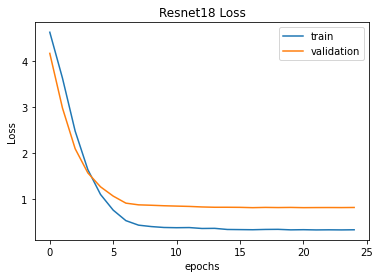

In [15]:
plot_curve(train_loss, val_loss, title='Resnet18 Loss', ylabel='Loss', legend_loc='upper right')

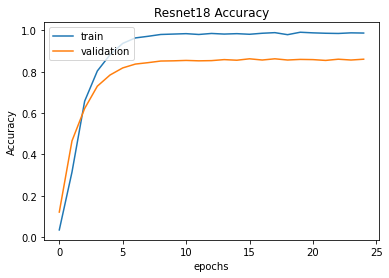

In [16]:
plot_curve(train_acc, val_acc, title='Resnet18 Accuracy', ylabel='Accuracy', legend_loc='upper left')

In [17]:
print('Train: ', end='')
validate(model, criterion, train_loader)

print('Validation: ', end='')
validate(model, criterion, validation_loader)

print('Test: ', end='')
validate(model, criterion, test_loader);

Train: 

100%|██████████| 16/16 [00:26<00:00,  1.66s/it]


Loss: 0.2795, Accuracy: 0.9902, Time taken: 26.5987s
Validation: 

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


Loss: 0.8217, Accuracy: 0.8608, Time taken: 9.4146s
Test: 

100%|██████████| 97/97 [00:56<00:00,  1.70it/s]

Loss: 0.8971, Accuracy: 0.8322, Time taken: 56.9890s


In [18]:
torch.save(model.state_dict(), "resnet18.pt")